# UIUC Wind Power with Echo State Networks

This notebook uses an Echo State Network(ESN) (from ``pyESN``) to predict
the electricity produced by the Railsplitter Wind farm.
All predictions in this notebook are optimized for 72 hour predictions. The
parameters will not generalize well to other prediction lengths because they
are optimized by looking at the mean squared error over the entire prediction
window.
In the future, the specific reactor design will motivate the size of the prediction
window.


The following items are included:
1. An initial demonstration of the ESN with a 72-hour prediction.
2. Grid optimization over spectral radius and noise
3. Grid optimization over reservoir size and sparsity
4. Demonstrate the effect of training length on accuracy.
5. A final demonstration of the ESN with optimized hyper-parameters.

### 1. Initial Demonstration

In [1]:
# import libraries
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# custom libraries
from tools import MSE
from pyESN.pyESN import ESN

In [2]:
# import demand data
dataframe = pd.read_csv("data/railsplitter_data.csv", usecols=['Time','MWh'])
windpower = np.array(dataframe.MWh).astype('float64')

# normalize
norm = np.linalg.norm(windpower)
windpower_norm = windpower/norm

In [3]:
tic = time.perf_counter()
n_reservoir= 1000
sparsity=0.1
rand_seed=85
spectral_radius = 1.5
# for regularization
noise = .0001


esn = ESN(n_inputs = 1,
      n_outputs = 1, 
      n_reservoir = n_reservoir,
      sparsity=sparsity,
      random_state=rand_seed,
      spectral_radius = spectral_radius,
      noise=noise)

trainlen = 8000
futureTotal=72
pred_tot=np.zeros(futureTotal)

# train the ESN
pred_training = esn.fit(np.ones(trainlen),windpower_norm[-trainlen-futureTotal:-futureTotal])
windpower_pred = esn.predict(np.ones(futureTotal))

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds.")
print(f"This simulation took {elapsed/60:0.02f} minutes.")

This simulation took 3.54 seconds.
This simulation took 0.06 minutes.


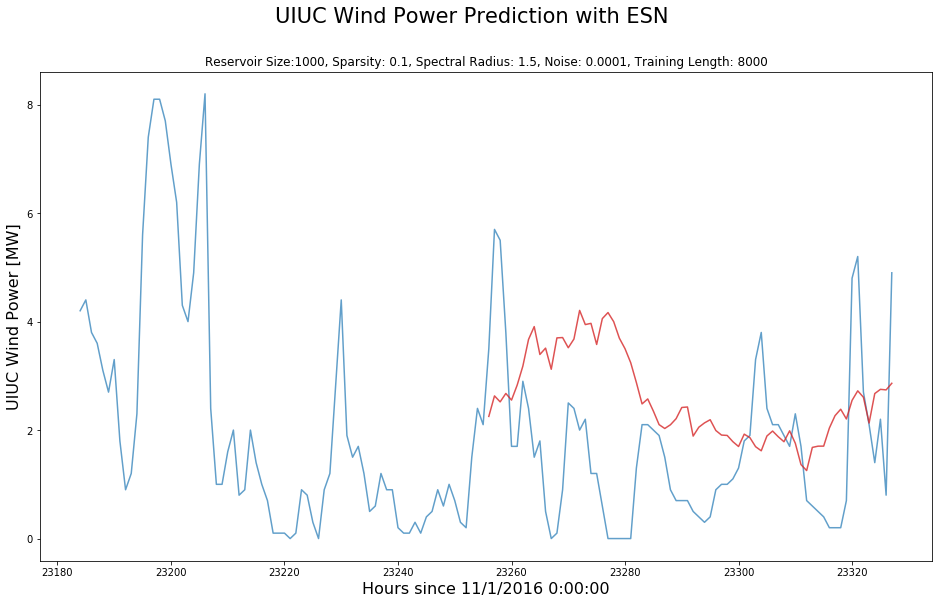

In [4]:
time_range = np.arange(0,len(windpower),1)

plt.figure(figsize=(16,9))
plt.suptitle("UIUC Wind Power Prediction with ESN", fontsize=21)
plt.title(f"Reservoir Size:{n_reservoir}, Sparsity: {sparsity}, Spectral Radius: {spectral_radius}, Noise: {noise}, Training Length: {trainlen}")
plt.ylabel("UIUC Wind Power [MW]", fontsize=16)
plt.xlabel("Hours since 11/1/2016 0:00:00", fontsize=16)

# plot the truth
plt.plot(time_range[-2*futureTotal:],norm*windpower_norm[-2*futureTotal:],'b',label="True Wind Power", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(time_range[-futureTotal:], norm*windpower_pred,  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')

### 2. Grid Optimization Over Spectral Radius and Noise

In [5]:
tic = time.perf_counter()
n_reservoir= 1000
sparsity=0.1
rand_seed=85

radius_set = [0.5, 0.7, 0.9,  1,  1.1,1.3,1.5]
noise_set = [ 0.0001, 0.0003,0.0007, 0.001, 0.003, 0.005, 0.007,0.01]

radius_set_size  = len(radius_set)
noise_set_size = len(noise_set)

trainlen = 8000
future = 1
futureTotal= 72

loss = np.zeros([radius_set_size, noise_set_size])

for l in range(radius_set_size):
    rho = radius_set[l]
    for j in range(noise_set_size):
        noise = noise_set[j]

        pred_tot=np.zeros(futureTotal)

        esn = ESN(n_inputs = 1,
              n_outputs = 1, 
              n_reservoir = n_reservoir,
              sparsity=sparsity,
              random_state=rand_seed,
              spectral_radius = rho,
              noise=noise)

        pred_training = esn.fit(np.ones(trainlen),windpower_norm[-trainlen-futureTotal:-futureTotal])
        windpower_pred = esn.predict(np.ones(futureTotal))
        
        loss[l, j] = MSE(windpower_pred, windpower_norm[-futureTotal:])        
        print('rho = ', radius_set[l], ', noise = ', noise_set[j], ', MSE = ', loss[l][j] )

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds.")
print(f"This simulation took {elapsed/60:0.02f} minutes.")

rho =  0.5 , noise =  0.0001 , MSE =  0.003457579111930997
rho =  0.5 , noise =  0.0003 , MSE =  0.003588244223615075
rho =  0.5 , noise =  0.0007 , MSE =  0.0036534856679433553
rho =  0.5 , noise =  0.001 , MSE =  0.0036677974889118914
rho =  0.5 , noise =  0.003 , MSE =  0.003699610238343512
rho =  0.5 , noise =  0.005 , MSE =  0.003708897237367963
rho =  0.5 , noise =  0.007 , MSE =  0.0037236755861651694
rho =  0.5 , noise =  0.01 , MSE =  0.0037562797445930556
rho =  0.7 , noise =  0.0001 , MSE =  0.0033486783521803802
rho =  0.7 , noise =  0.0003 , MSE =  0.003467691950508525
rho =  0.7 , noise =  0.0007 , MSE =  0.0035669331185297975
rho =  0.7 , noise =  0.001 , MSE =  0.0036049659258708963
rho =  0.7 , noise =  0.003 , MSE =  0.003673465370361054
rho =  0.7 , noise =  0.005 , MSE =  0.0036873509263728355
rho =  0.7 , noise =  0.007 , MSE =  0.0036975814976614937
rho =  0.7 , noise =  0.01 , MSE =  0.0037174255426993563
rho =  0.9 , noise =  0.0001 , MSE =  0.003213160412601401

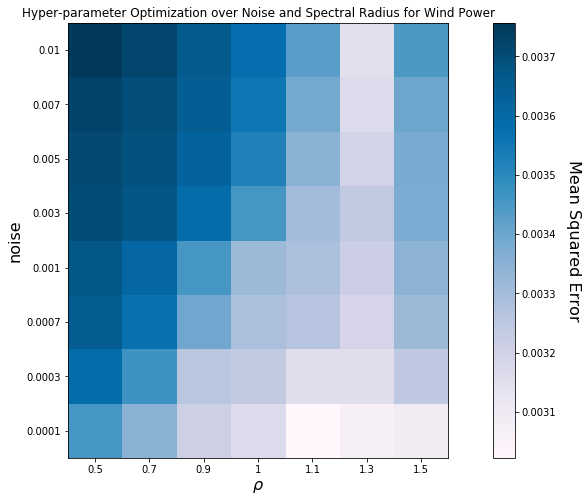

In [6]:
plt.figure(figsize=(16,8))
plt.title("Hyper-parameter Optimization over Noise and Spectral Radius for Wind Power")
im = plt.imshow(loss.T, vmin=abs(loss).min(), vmax=abs(loss).max(), origin='lower',cmap='plasma')
# im = plt.imshow(loss.T, vmin=abs(loss).min(), vmax=abs(loss).max(), origin='lower',cmap='PuBu')
plt.xticks(np.linspace(0,radius_set_size-1,radius_set_size), radius_set);
plt.yticks(np.linspace(0,noise_set_size-1, noise_set_size), noise_set);
plt.xlabel(r'$\rho$', fontsize=16); plt.ylabel('noise', fontsize=16); 
# im.set_interpolation('bilinear')
cb = plt.colorbar(im); 
cb.set_label(label="Mean Squared Error", fontsize=16, rotation=-90, labelpad=25);

In [7]:
minLoss = np.min(loss)
index_min = np.where(loss == minLoss)
index_min
rho_opt = radius_set[int(index_min[0])]
noise_opt = noise_set[int(index_min[1])]
print('The optimal set is:\nspectrum radius = ',
      rho_opt,'\nnoise = ',noise_opt,'\nMSE = ',minLoss)

The optimal set is:
spectrum radius =  1.1 
noise =  0.0001 
MSE =  0.0030223605373325864


### 3. Grid Optimization Over Reservoir Size and Sparsity

The algorithm is unstable when ``n_reservoir == trainlen``.

In [8]:
tic = time.perf_counter()
rho = rho_opt
noise = noise_opt
rand_seed=85

reservoir_set = [600, 800, 1000, 1500, 2000, 3000, 4000]
sparsity_set = [0.005, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2]

reservoir_set_size  = len(reservoir_set)
sparsity_set_size = len(sparsity_set)

trainlen = 8000
future = 1
futureTotal= 72

loss = np.zeros([reservoir_set_size, sparsity_set_size])

for l in range(reservoir_set_size):
    n_reservoir = reservoir_set[l]
    for j in range(sparsity_set_size):
        sparsity = sparsity_set[j]

        pred_tot=np.zeros(futureTotal)

        esn = ESN(n_inputs = 1,
              n_outputs = 1, 
              n_reservoir = n_reservoir,
              sparsity=sparsity,
              random_state=rand_seed,
              spectral_radius = rho,
              noise=noise)

        pred_training = esn.fit(np.ones(trainlen),windpower_norm[-trainlen-futureTotal:-futureTotal])
        windpower_pred = esn.predict(np.ones(futureTotal))
        
        loss[l, j] = MSE(windpower_pred, windpower_norm[-futureTotal:])        
        print('n_reservoir = ', reservoir_set[l], ', sparsity = ', sparsity_set[j], ', MSE = ', loss[l][j] )
        
toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds.")
print(f"This simulation took {elapsed/60:0.02f} minutes.")

n_reservoir =  600 , sparsity =  0.005 , MSE =  0.0034712361970967807
n_reservoir =  600 , sparsity =  0.01 , MSE =  0.003571771319603889
n_reservoir =  600 , sparsity =  0.03 , MSE =  0.0033864065541535514
n_reservoir =  600 , sparsity =  0.05 , MSE =  0.0033273526986038813
n_reservoir =  600 , sparsity =  0.1 , MSE =  0.003170292878327415
n_reservoir =  600 , sparsity =  0.15 , MSE =  0.003133029316746744
n_reservoir =  600 , sparsity =  0.2 , MSE =  0.0028028603383786943
n_reservoir =  800 , sparsity =  0.005 , MSE =  0.0037074908950252834
n_reservoir =  800 , sparsity =  0.01 , MSE =  0.0038260533024027064
n_reservoir =  800 , sparsity =  0.03 , MSE =  0.0036680234646210117
n_reservoir =  800 , sparsity =  0.05 , MSE =  0.003427794086136492
n_reservoir =  800 , sparsity =  0.1 , MSE =  0.0037474155584392398
n_reservoir =  800 , sparsity =  0.15 , MSE =  0.003470759704024816
n_reservoir =  800 , sparsity =  0.2 , MSE =  0.00326415749722977
n_reservoir =  1000 , sparsity =  0.005 , M

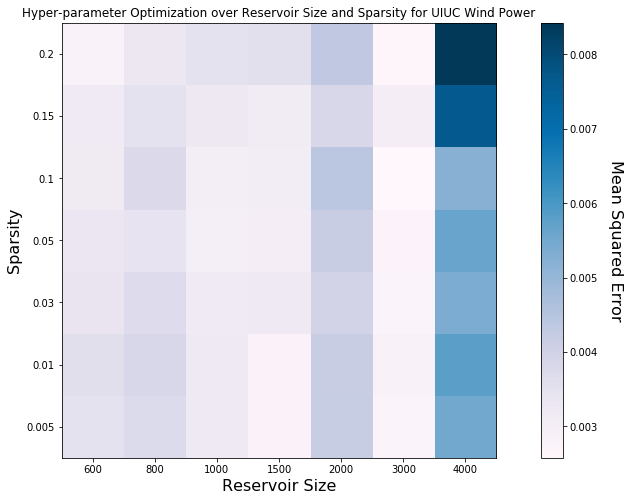

In [9]:
plt.figure(figsize=(16,8))
plt.title("Hyper-parameter Optimization over Reservoir Size and Sparsity for UIUC Wind Power")
im = plt.imshow(loss.T, vmin=abs(loss).min(), vmax=abs(loss).max(), origin='lower',cmap='PuBu')
plt.xticks(np.linspace(0,reservoir_set_size-1,reservoir_set_size), reservoir_set);
plt.yticks(np.linspace(0,sparsity_set_size-1, sparsity_set_size), sparsity_set);
plt.xlabel(r'Reservoir Size', fontsize=16); plt.ylabel('Sparsity', fontsize=16); 
# im.set_interpolation('bilinear')
cb = plt.colorbar(im); 
cb.set_label(label="Mean Squared Error", fontsize=16, rotation=-90, labelpad=25);

In [10]:
minLoss = np.min(loss)
index_min = np.where(loss == minLoss)
index_min
n_opt = reservoir_set[int(index_min[0])]
s_opt = sparsity_set[int(index_min[1])]
print('The optimal set is:\nreservoir_size = ',
      n_opt,'\nsparsity = ',s_opt,'\nMSE = ',minLoss)

The optimal set is:
reservoir_size =  3000 
sparsity =  0.1 
MSE =  0.0025774753488092155


### 4. Demonstrate the Effect of Training Length

Once again, the algorithm is unstable when ``n_reservoir == trainlen``.

We should expect that MSE will decrease as training length increases.

In [12]:
tic = time.perf_counter()
# optimal set of n_reservoir and sparsity
n_reservoir= n_opt
sparsity = s_opt

# optimal set of spectral_radius and noise
spectral_radius = rho_opt
# for regularization
noise = noise_opt

rand_seed=85

trainingLengths = np.arange(4000,22000,300)
futureTotal=72

loss_k = np.zeros(len(trainingLengths))

for l in range(len(trainingLengths)):
    trainlen = trainingLengths[l]   

    esn = ESN(n_inputs = 1,
          n_outputs = 1, 
          n_reservoir = n_reservoir,
          sparsity=sparsity,
          random_state=rand_seed,
          spectral_radius = spectral_radius,
          noise=noise)


    pred_training = esn.fit(np.ones(trainlen),windpower_norm[-trainlen-futureTotal:-futureTotal])
    windpower_pred = esn.predict(np.ones(futureTotal))
        
    loss_k[l] = MSE(windpower_pred, windpower_norm[-futureTotal:]) 
    
    print(f"Training length = {trainlen}, MSE = {loss_k[l]}")
    
toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds.")
print(f"This simulation took {elapsed/60:0.02f} minutes.")

Training length = 4000, MSE = 0.008986576792881305
Training length = 4300, MSE = 0.010601884360045282
Training length = 4600, MSE = 0.005586137339274948
Training length = 4900, MSE = 0.006118724631967296
Training length = 5200, MSE = 0.007322472139881491
Training length = 5500, MSE = 0.0066018305504245015
Training length = 5800, MSE = 0.005143183067632208
Training length = 6100, MSE = 0.006148515699978655
Training length = 6400, MSE = 0.004373016024791068
Training length = 6700, MSE = 0.0051785132125886585
Training length = 7000, MSE = 0.004160500452209016
Training length = 7300, MSE = 0.0024463198482670193
Training length = 7600, MSE = 0.004865132112369033
Training length = 7900, MSE = 0.003978396923888001
Training length = 8200, MSE = 0.0035358258226194216
Training length = 8500, MSE = 0.0063042540130237345
Training length = 8800, MSE = 0.0030951310298311494
Training length = 9100, MSE = 0.003987000017196681
Training length = 9400, MSE = 0.004450189143562143
Training length = 9700, M

Text(0, 0.5, 'MSE')

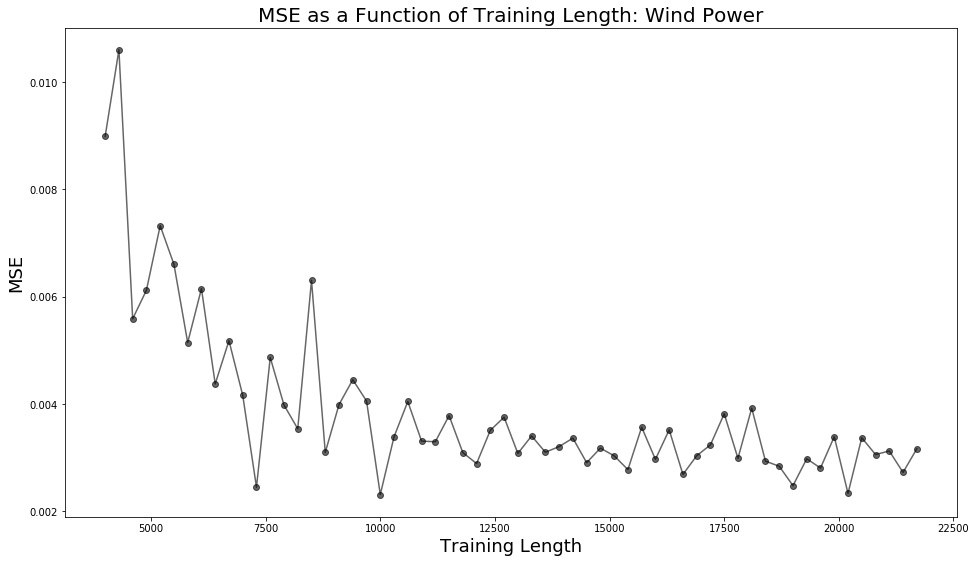

In [16]:
plt.figure(figsize=(16,9))
plt.plot(trainingLengths, loss_k,'-ok', alpha=0.6)
plt.title('MSE as a Function of Training Length: Wind Power', fontsize=20)
plt.xlabel('Training Length', fontsize=18)
plt.ylabel('MSE', fontsize=18)

In [17]:
minloss = np.min(loss_k)
index_min = np.where(loss_k == minloss)
l_opt = trainingLengths[index_min][0]

print(f"Training length with minimum error was: {l_opt}")

Training length with minimum error was: 10000


### 5. Final Optimized ESN

In [22]:
tic = time.perf_counter()
n_reservoir= n_opt
sparsity=s_opt
rand_seed=85
spectral_radius = rho_opt
# for regularization
noise = noise_opt


esn = ESN(n_inputs = 1,
      n_outputs = 1, 
      n_reservoir = n_reservoir,
      sparsity=sparsity,
      random_state=rand_seed,
      spectral_radius = spectral_radius,
      noise=noise)

trainlen = l_opt
# trainlen = 26000
futureTotal=72

# train the ESN
pred_training = esn.fit(np.ones(trainlen),windpower_norm[-trainlen-futureTotal:-futureTotal])
windpower_pred = esn.predict(np.ones(futureTotal))
toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds.")
print(f"This simulation took {elapsed/60:0.02f} minutes.")

This simulation took 56.87 seconds.
This simulation took 0.95 minutes.


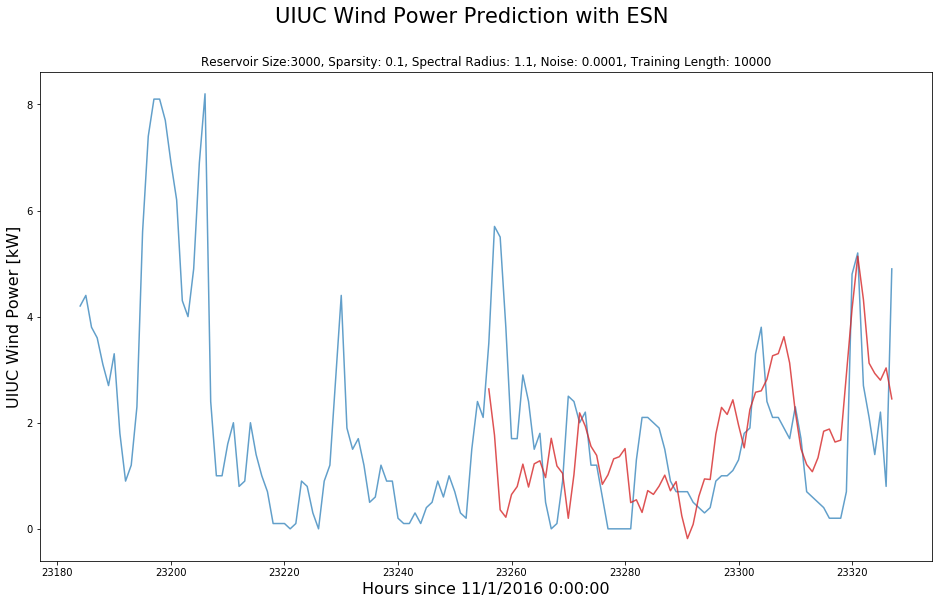

In [23]:
time_range = np.arange(0,len(windpower),1)

plt.figure(figsize=(16,9))
plt.suptitle("UIUC Wind Power Prediction with ESN", fontsize=21)
plt.title(f"Reservoir Size:{n_reservoir}, Sparsity: {sparsity}, Spectral Radius: {spectral_radius}, Noise: {noise}, Training Length: {trainlen}")
plt.ylabel("UIUC Wind Power [kW]", fontsize=16)
plt.xlabel("Hours since 11/1/2016 0:00:00", fontsize=16)

# plot the truth
plt.plot(time_range[-2*futureTotal:],norm*windpower_norm[-2*futureTotal:],'b',label="True Wind Power", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(time_range[-futureTotal:], norm*windpower_pred,  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')

### 5b. Check the sub optimal training length value

In [24]:
tic = time.perf_counter()
n_reservoir= n_opt
sparsity=s_opt
rand_seed=85
spectral_radius = rho_opt
# for regularization
noise = noise_opt


esn = ESN(n_inputs = 1,
      n_outputs = 1, 
      n_reservoir = n_reservoir,
      sparsity=sparsity,
      random_state=rand_seed,
      spectral_radius = spectral_radius,
      noise=noise)

# trainlen = l_opt
trainlen = 20200
futureTotal=72

# train the ESN
pred_training = esn.fit(np.ones(trainlen),windpower_norm[-trainlen-futureTotal:-futureTotal])
windpower_pred = esn.predict(np.ones(futureTotal))
toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds.")
print(f"This simulation took {elapsed/60:0.02f} minutes.")

This simulation took 119.87 seconds.
This simulation took 2.00 minutes.


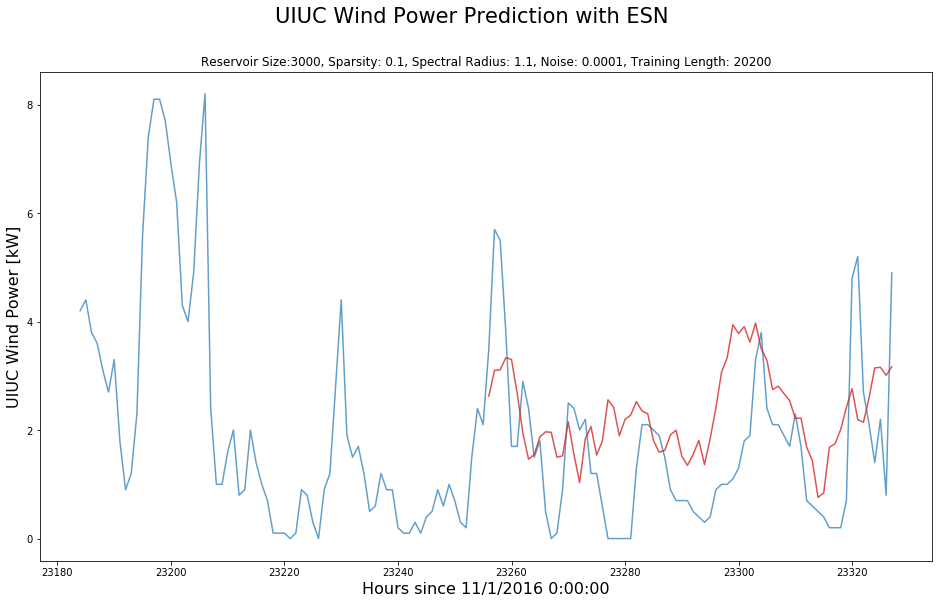

In [25]:
time_range = np.arange(0,len(windpower),1)

plt.figure(figsize=(16,9))
plt.suptitle("UIUC Wind Power Prediction with ESN", fontsize=21)
plt.title(f"Reservoir Size:{n_reservoir}, Sparsity: {sparsity}, Spectral Radius: {spectral_radius}, Noise: {noise}, Training Length: {trainlen}")
plt.ylabel("UIUC Wind Power [kW]", fontsize=16)
plt.xlabel("Hours since 11/1/2016 0:00:00", fontsize=16)

# plot the truth
plt.plot(time_range[-2*futureTotal:],norm*windpower_norm[-2*futureTotal:],'b',label="True Wind Power", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(time_range[-futureTotal:], norm*windpower_pred,  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')